# Sentence Embedding
Riordan Callil 2021
Honours research
Developing an instruction understanding robot
Current design: Instruction understanding using sentence embedding. Sentence embedding network will be trained in two phases. (1) Trained as a sentence autoencoder. Using the translation encoder-decoder framework. I will train the network to reconstruct the initial instruction from the latent representation. (2) I will fine tune the networks latent representations by training a classifier that uses the latent space to predict instruction action. (3) (FUTURE) As an additional step I might train the sentence autoencoder to translate high level instructions to low level instructions and visa versa. 

# Utils

In [2]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.show()

# Dataset: ALFRED

In [3]:
import tqdm
import glob
import json
import string
import torchtext
from torchtext.data import get_tokenizer
from nltk.stem import WordNetLemmatizer

# Loading and Transforming the ALFRED dataset utilites

def load_next_alfred_data(ALFRED_JSON_PATTERN):
    """
     Get list of all instructions and their trajectories
     glob.glob gets all files and stores them. iglob makes an iterator.
     
    Paramaters:
        @alfred_json_pattern
        A string which represents the location of the data with glob style
        regex expressions to denote multiple subdirectories.
    """ 
    train_json_files = glob.glob(ALFRED_JSON_PATTERN)
    tokenizer = get_tokenizer("basic_english")
    wnl = WordNetLemmatizer()
    dataset = []
    
    def preprocess_sentence(sentence):
        sentence = tokenizer(sentence)
        sentence = filter(lambda x: not x in string.punctuation, sentence)
        sentence = [wnl.lemmatize(word) for word in sentence]
        return sentence
    
    # Yeild an alfred json
    for json_file_idx in tqdm.tqdm(range(len(train_json_files))):
        data = json.load(open(train_json_files[json_file_idx]))
        annotations = data['turk_annotations']['anns']
        actions = data['plan']['high_pddl']
        scene = data['scene']
        scene['task_id'] = data['task_id']
        
        instruction_actions = []
        for d in annotations:
            votes = d['votes']
            if all(votes): # WARNING: Limiting dataset based on votes
                trajectory = {'task_desc': [], 'instructions': []}
                trajectory['task_desc'] = preprocess_sentence(d['task_desc'])
                for i in range(len(d['high_descs'])):
                    sanitized_instruction = preprocess_sentence(d['high_descs'][i])
                    #sanitized_instruction = tokenizer(d['high_descs'][i])
                    #sanitized_instruction = filter(lambda x: not x in string.punctuation,sanitized_instruction)
                    #sanitized_instruction = [wnl.lemmatize(word) for word in sanitized_instruction]
                    instruction = {'instruction': sanitized_instruction, 
                                   'action': actions[i]['discrete_action']['action'],
                                   'argument_1': actions[i]['discrete_action']['args'][0] if 0 < len(actions[i]['discrete_action']['args']) else '<unk>', 
                                   'argument_2': actions[i]['discrete_action']['args'][1] if 1 < len(actions[i]['discrete_action']['args']) else '<unk>'}
                    trajectory['instructions'].append(instruction)
                instruction_actions.append(trajectory)

        if len(instruction_actions) > 0:
            dataset.append((instruction_actions, scene))
    return dataset

train_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/train/*/*/*.json")
eval_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json")

100%|███████████████████████████████████████████████████████████| 255/255 [00:02<00:00, 90.30it/s]


In [4]:
import json
import os

class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def add_sentence(self, sentence):
        for word in sentence:
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index: # Add word to langauge if unseen 
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word(self, index):
        return self.index2word.get(str(index))
    
    def index(self, word):
        return self.word2index.get(word)
    
    def dump(self, filename):
        obj = {
            'word2index' : self.word2index,
            'word2count' : self.word2count,
            'index2word' : self.index2word,
            'n_words' : self.n_words
        }
        with open(filename, 'w') as fp:
            json.dump(obj, fp)
    
    def load(self, filename):
        with open(filename, 'r') as fp:
            obj = json.load(fp)
            self.word2index = obj['word2index']
            self.word2count = obj['word2count']
            self.index2word = obj['index2word']
            self.n_words = obj['n_words']
    
    def reset_counts(self):
        self.word2count = dict.fromkeys(self.word2count, 0)

# Check if backup, pickled, langauge object exists
lang = Language()
if os.path.isfile('instruction_language.json'):
    lang.load('instruction_language.json')
    lang.reset_counts()

action_lang = Language()
if os.path.isfile('action_language.json'):
    action_lang.load('action_language.json')
    action_lang.reset_counts()

argument_lang = Language()
if os.path.isfile('argument_language.json'):
    argument_lang.load('argument_language.json')
    argument_lang.reset_counts()

lang.add_sentence(["<SOS>", "<EOS>"])
action_lang.add_sentence(["<SOS>", "<EOS>"])
argument_lang.add_sentence(["<SOS>", "<EOS>"])

def add_dataset_to_language(lang, dataset):
    sentence_lengths = []
    # Add dataset to langauge object
    for task in tqdm.tqdm(dataset): 
        for trajectory in task[0]:
            lang.add_sentence(trajectory['task_desc'])
            sentence_lengths.append(len(trajectory['task_desc']))
            for instruction in trajectory['instructions']:
                instruction_text = instruction['instruction']
                instruction_action = instruction['action']
                instruction_arg_1 = instruction['argument_1']
                instruction_arg_2 = instruction['argument_2']
                if len(instruction_text) > 0:
                    lang.add_sentence(instruction_text)
                action_lang.add_word(instruction_action)
                if instruction_arg_1 != '<unk>':
                    lang.add_word(instruction_arg_1)
                    argument_lang.add_word(instruction_arg_1)
                if instruction_arg_2 != '<unk>':
                    lang.add_word(instruction_arg_2)
                    argument_lang.add_word(instruction_arg_2)
                
            sentence_lengths.append(len(instruction_text))
    return sentence_lengths
                    
sentence_lengths = add_dataset_to_language(lang, train_dataset)
eval_sentence_lengths = add_dataset_to_language(lang, eval_dataset)
sentence_lengths.extend(eval_sentence_lengths)

print('average sentence length = %.2f words' % (sum(sentence_lengths) / len(sentence_lengths)))

# Pickle the language as a backup
lang.dump('instruction_language.json')
action_lang.dump('action_language.json')
argument_lang.dump('argument_language.json')

print('vocab size =', lang.n_words)
print('most common words: ', sorted(lang.word2count.items(), key=lambda item: item[1], reverse=True)[:10])
print('most common actions: ', sorted(action_lang.word2count.items(), key=lambda item: item[1], reverse=True))
print('number of arguments = ', argument_lang.n_words)

print(action_lang.word2index)
print(argument_lang.word2index)

100%|████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 11043.71it/s]

average sentence length = 9.84 words
vocab size = 1947
most common words:  [('the', 314034), ('to', 88329), ('turn', 65997), ('and', 60512), ('on', 51078), ('of', 50848), ('right', 40425), ('left', 39517), ('in', 33950), ('a', 30771)]
most common actions:  [('GotoLocation', 62568), ('PickupObject', 28419), ('PutObject', 26162), ('CoolObject', 2761), ('SliceObject', 2737), ('HeatObject', 2727), ('CleanObject', 2603), ('ToggleObject', 2166), ('<SOS>', 1), ('<EOS>', 1)]
number of arguments =  83
{'<SOS>': 0, '<EOS>': 1, 'GotoLocation': 2, 'PickupObject': 3, 'ToggleObject': 4, 'PutObject': 5, 'SliceObject': 6, 'CleanObject': 7, 'CoolObject': 8, 'HeatObject': 9}
{'<SOS>': 0, '<EOS>': 1, 'dresser': 2, 'alarmclock': 3, 'desklamp': 4, 'desk': 5, 'shelf': 6, 'sidetable': 7, 'baseballbat': 8, 'basketball': 9, 'book': 10, 'bed': 11, 'bowl': 12, 'sofa': 13, 'box': 14, 'coffeetable': 15, 'diningtable': 16, 'floorlamp': 17, 'candle': 18, 'cd': 19, 'drawer': 20, 'garbagecan': 21, 'cellphone': 22, 'ar

In [5]:
###### Train Cirriculum ######
train_reconstruction = [] # [any text, any text]
train_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
train_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(train_dataset):
    for trajectory in task[0]:
        train_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                train_reconstruction.append(instruction_text)
                train_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                train_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('train reconstruction samples =', len(train_reconstruction))
print('train high -> low pairs =', len(train_high_low_pairs))
print('train low -> action / argument pairs =', len(train_low_action_argument_pairs))

###### Eval Cirriculum ######
eval_reconstruction = [] # [any text, any text]
eval_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
eval_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(eval_dataset):
    for trajectory in task[0]:
        eval_reconstruction.append(trajectory['task_desc'])
        for instruction in trajectory['instructions']:
            instruction_text = instruction['instruction']
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                eval_reconstruction.append(instruction_text)
                eval_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                eval_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('eval reconstruction samples =', len(eval_reconstruction))
print('eval high -> low pairs =', len(eval_high_low_pairs))
print('eval low -> action / argument pairs =', len(eval_low_action_argument_pairs))

import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

# Prepare data for tensor representation
def indices_from_sentence(lang, sentence):
    return [lang.index(word) for word in sentence]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    indices.append(lang.index('<EOS>'))
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1,1)

def tensors_from_pair(input_lang, output_lang, pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

rpair = random.choice(train_low_action_argument_pairs)
print(rpair)
print(tensors_from_pair(lang, action_lang, [rpair[0], rpair[1]]))

100%|████████████████████████████████████████████████████████| 254/254 [00:00<00:00, 36301.95it/s]


train reconstruction samples = 144336
train high -> low pairs = 125571
train low -> action / argument pairs = 125571
eval reconstruction samples = 5304
eval high -> low pairs = 4572
eval low -> action / argument pairs = 4572
using device: cuda
[['put', 'the', 'cd', 'on', 'the', 'upper', 'shelf', 'to', 'the', 'right', 'of', 'the', 'clock'], ['PutObject'], ['cd', 'shelf']]
(tensor([[267],
        [  4],
        [ 59],
        [  9],
        [  4],
        [250],
        [ 68],
        [ 25],
        [  4],
        [ 32],
        [ 27],
        [  4],
        [  6],
        [  1]], device='cuda:0'), tensor([[5],
        [1]], device='cuda:0'))


# Model

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

MAX_LENGTH = 10

# Sourced from Pytorch Tutorial: Seq2Seq Translation Tutorial
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class ActionPredictor(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(ActionPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        
        self.linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.linear2 = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input):
        output = F.relu(self.linear1(input))
        output = self.dropout(output)
        output = F.log_softmax(self.linear2(output), dim=0)
        return output

# Train - Action Predictor

updates:  108868
0m 0s (- 11m 1s) (100 0%) 0.1183
0m 1s (- 10m 42s) (200 0%) 0.0088
0m 1s (- 10m 45s) (300 0%) 0.0167
0m 2s (- 10m 47s) (400 0%) 0.2675
0m 2s (- 10m 45s) (500 0%) 0.0853
0m 3s (- 10m 36s) (600 0%) 0.0034
0m 4s (- 10m 35s) (700 0%) 0.0030
0m 4s (- 10m 32s) (800 0%) 0.0023
0m 5s (- 10m 27s) (900 0%) 0.0018
0m 5s (- 10m 24s) (1000 0%) 0.0018
0m 6s (- 10m 24s) (1100 1%) 0.0027
0m 6s (- 10m 21s) (1200 1%) 0.0056
0m 7s (- 10m 20s) (1300 1%) 0.0724
0m 8s (- 10m 20s) (1400 1%) 0.0020
0m 8s (- 10m 18s) (1500 1%) 0.0007
0m 9s (- 10m 17s) (1600 1%) 0.0019
0m 9s (- 10m 17s) (1700 1%) 0.0618
0m 10s (- 10m 14s) (1800 1%) 0.0026
0m 10s (- 10m 13s) (1900 1%) 0.0153
0m 11s (- 10m 15s) (2000 1%) 0.0769
0m 12s (- 10m 16s) (2100 1%) 0.0018
0m 12s (- 10m 17s) (2200 2%) 0.0028
0m 13s (- 10m 19s) (2300 2%) 0.0016
0m 14s (- 10m 21s) (2400 2%) 0.0011
0m 14s (- 10m 22s) (2500 2%) 0.0016
0m 15s (- 10m 23s) (2600 2%) 0.0024
0m 15s (- 10m 23s) (2700 2%) 0.0022
0m 16s (- 10m 23s) (2800 2%) 0.0011
0m

2m 21s (- 8m 53s) (22800 20%) 0.0016
2m 22s (- 8m 53s) (22900 21%) 0.0231
2m 22s (- 8m 52s) (23000 21%) 0.0036
2m 23s (- 8m 51s) (23100 21%) 0.0014
2m 23s (- 8m 51s) (23200 21%) 0.0176
2m 24s (- 8m 50s) (23300 21%) 0.0046
2m 25s (- 8m 49s) (23400 21%) 0.1482
2m 25s (- 8m 49s) (23500 21%) 0.2306
2m 26s (- 8m 48s) (23600 21%) 0.0102
2m 26s (- 8m 47s) (23700 21%) 0.1920
2m 27s (- 8m 47s) (23800 21%) 0.0392
2m 28s (- 8m 46s) (23900 21%) 0.0169
2m 28s (- 8m 45s) (24000 22%) 0.0528
2m 29s (- 8m 45s) (24100 22%) 0.0038
2m 29s (- 8m 44s) (24200 22%) 0.1475
2m 30s (- 8m 44s) (24300 22%) 0.0066
2m 31s (- 8m 43s) (24400 22%) 0.0061
2m 31s (- 8m 42s) (24500 22%) 0.0031
2m 32s (- 8m 42s) (24600 22%) 0.0013
2m 33s (- 8m 41s) (24700 22%) 0.0745
2m 33s (- 8m 40s) (24800 22%) 0.0538
2m 34s (- 8m 40s) (24900 22%) 0.0053
2m 34s (- 8m 39s) (25000 22%) 0.0050
2m 35s (- 8m 38s) (25100 23%) 0.0161
2m 36s (- 8m 38s) (25200 23%) 0.0511
2m 36s (- 8m 37s) (25300 23%) 0.0447
2m 37s (- 8m 37s) (25400 23%) 0.0607
2

4m 40s (- 6m 35s) (45200 41%) 0.0066
4m 41s (- 6m 35s) (45300 41%) 0.0032
4m 42s (- 6m 34s) (45400 41%) 0.0048
4m 42s (- 6m 33s) (45500 41%) 0.0011
4m 43s (- 6m 33s) (45600 41%) 0.0057
4m 44s (- 6m 32s) (45700 41%) 0.0019
4m 44s (- 6m 32s) (45800 42%) 0.0011
4m 45s (- 6m 31s) (45900 42%) 0.0130
4m 45s (- 6m 30s) (46000 42%) 0.0006
4m 46s (- 6m 30s) (46100 42%) 0.0006
4m 47s (- 6m 29s) (46200 42%) 0.0009
4m 47s (- 6m 28s) (46300 42%) 0.0011
4m 48s (- 6m 28s) (46400 42%) 0.2224
4m 48s (- 6m 27s) (46500 42%) 0.0364
4m 49s (- 6m 26s) (46600 42%) 0.0171
4m 50s (- 6m 26s) (46700 42%) 0.0017
4m 50s (- 6m 25s) (46800 42%) 0.1395
4m 51s (- 6m 25s) (46900 43%) 0.0031
4m 52s (- 6m 24s) (47000 43%) 0.0019
4m 52s (- 6m 23s) (47100 43%) 0.0378
4m 53s (- 6m 23s) (47200 43%) 0.0019
4m 54s (- 6m 22s) (47300 43%) 0.0053
4m 54s (- 6m 22s) (47400 43%) 0.0048
4m 55s (- 6m 21s) (47500 43%) 0.0023
4m 55s (- 6m 20s) (47600 43%) 0.0027
4m 56s (- 6m 20s) (47700 43%) 0.0045
4m 57s (- 6m 19s) (47800 43%) 0.0014
4

7m 3s (- 4m 18s) (67600 62%) 0.0119
7m 4s (- 4m 18s) (67700 62%) 0.0685
7m 4s (- 4m 17s) (67800 62%) 0.0310
7m 5s (- 4m 16s) (67900 62%) 0.0144
7m 6s (- 4m 16s) (68000 62%) 0.0941
7m 6s (- 4m 15s) (68100 62%) 0.0695
7m 7s (- 4m 14s) (68200 62%) 0.0242
7m 8s (- 4m 14s) (68300 62%) 0.0804
7m 8s (- 4m 13s) (68400 62%) 0.0815
7m 9s (- 4m 13s) (68500 62%) 0.0159
7m 10s (- 4m 12s) (68600 63%) 0.0073
7m 10s (- 4m 11s) (68700 63%) 0.0032
7m 11s (- 4m 11s) (68800 63%) 0.0034
7m 12s (- 4m 10s) (68900 63%) 0.1554
7m 12s (- 4m 10s) (69000 63%) 0.0180
7m 13s (- 4m 9s) (69100 63%) 0.0118
7m 14s (- 4m 8s) (69200 63%) 0.1026
7m 14s (- 4m 8s) (69300 63%) 0.0050
7m 15s (- 4m 7s) (69400 63%) 0.0066
7m 16s (- 4m 7s) (69500 63%) 0.0213
7m 16s (- 4m 6s) (69600 63%) 0.0041
7m 17s (- 4m 5s) (69700 64%) 0.0037
7m 18s (- 4m 5s) (69800 64%) 0.0041
7m 18s (- 4m 4s) (69900 64%) 0.0026
7m 19s (- 4m 3s) (70000 64%) 0.0022
7m 20s (- 4m 3s) (70100 64%) 0.0026
7m 20s (- 4m 2s) (70200 64%) 0.0026
7m 21s (- 4m 2s) (70300

9m 27s (- 1m 58s) (90000 82%) 0.1285
9m 28s (- 1m 58s) (90100 82%) 0.0082
9m 28s (- 1m 57s) (90200 82%) 0.0552
9m 29s (- 1m 57s) (90300 82%) 0.0040
9m 30s (- 1m 56s) (90400 83%) 0.0765
9m 30s (- 1m 55s) (90500 83%) 0.0044
9m 31s (- 1m 55s) (90600 83%) 0.1951
9m 32s (- 1m 54s) (90700 83%) 0.0050
9m 32s (- 1m 53s) (90800 83%) 0.0049
9m 33s (- 1m 53s) (90900 83%) 0.0163
9m 33s (- 1m 52s) (91000 83%) 0.1032
9m 34s (- 1m 52s) (91100 83%) 0.0465
9m 35s (- 1m 51s) (91200 83%) 0.0379
9m 35s (- 1m 50s) (91300 83%) 0.1650
9m 36s (- 1m 50s) (91400 83%) 0.0154
9m 37s (- 1m 49s) (91500 84%) 0.0080
9m 37s (- 1m 48s) (91600 84%) 0.0196
9m 38s (- 1m 48s) (91700 84%) 0.0600
9m 39s (- 1m 47s) (91800 84%) 0.0075
9m 39s (- 1m 47s) (91900 84%) 0.0064
9m 40s (- 1m 46s) (92000 84%) 0.0653
9m 40s (- 1m 45s) (92100 84%) 0.3127
9m 41s (- 1m 45s) (92200 84%) 0.0149
9m 42s (- 1m 44s) (92300 84%) 0.0179
9m 42s (- 1m 43s) (92400 84%) 0.0174
9m 43s (- 1m 43s) (92500 84%) 0.0069
9m 44s (- 1m 42s) (92600 85%) 0.0037
9

<Figure size 432x288 with 0 Axes>

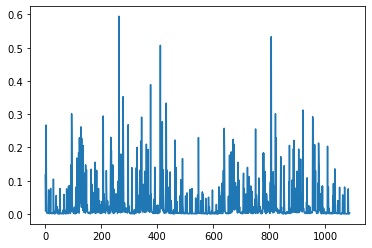

In [37]:
def train(input_tensor, target_action, encoder, predictor, encoder_optimizer, predictor_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    predictor_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    # Without teacher forcing: use its own predictions as the next input
    predictor_output = predictor(encoder_hidden.flatten())
    topv, topi = predictor_output.topk(1)
    #predictor_output = topi.squeeze().detach()  # detach from history as input
    loss = criterion(predictor_output.unsqueeze(dim=0), target_action)

    loss.backward()
    
    encoder_optimizer.step()
    predictor_optimizer.step()

    return loss.item()

hidden_size = 256
learning_rate = 0.01
epochs = 2
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt'))

start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(action_predictor.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[1]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(action_lang, training_pair[1])[0]

        loss = train(input_tensor, target_tensor, encoder,
                     action_predictor, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(action_predictor.state_dict(), 'action_predictor.pt')

show_plot(plot_losses)

# Train - Argument Decoder

updates:  108868
0m 1s (- 19m 16s) (100 0%) 0.2631
0m 2s (- 18m 42s) (200 0%) 0.2108
0m 3s (- 18m 33s) (300 0%) 0.1878
0m 4s (- 18m 21s) (400 0%) 0.2510
0m 5s (- 18m 18s) (500 0%) 0.0710
0m 6s (- 18m 11s) (600 0%) 0.1413
0m 7s (- 18m 12s) (700 0%) 0.1551
0m 8s (- 18m 11s) (800 0%) 0.1982
0m 9s (- 18m 5s) (900 0%) 0.1921
0m 10s (- 18m 6s) (1000 0%) 0.1352
0m 11s (- 18m 9s) (1100 1%) 0.1218
0m 12s (- 18m 4s) (1200 1%) 0.2430
0m 13s (- 18m 0s) (1300 1%) 0.2380
0m 14s (- 17m 58s) (1400 1%) 0.1956
0m 15s (- 17m 54s) (1500 1%) 0.1151
0m 16s (- 17m 53s) (1600 1%) 0.1113
0m 16s (- 17m 50s) (1700 1%) 0.0558
0m 17s (- 17m 44s) (1800 1%) 0.0414
0m 18s (- 17m 42s) (1900 1%) 0.1449
0m 19s (- 17m 42s) (2000 1%) 0.2577
0m 20s (- 17m 44s) (2100 1%) 0.1787
0m 21s (- 17m 43s) (2200 2%) 0.2834
0m 22s (- 17m 43s) (2300 2%) 0.2113
0m 24s (- 17m 46s) (2400 2%) 0.1604
0m 25s (- 17m 46s) (2500 2%) 0.0774
0m 26s (- 17m 46s) (2600 2%) 0.0486
0m 27s (- 17m 45s) (2700 2%) 0.0643
0m 28s (- 17m 44s) (2800 2%) 0.175

4m 10s (- 16m 1s) (22500 20%) 0.1164
4m 11s (- 16m 0s) (22600 20%) 0.1439
4m 12s (- 15m 59s) (22700 20%) 0.0938
4m 13s (- 15m 58s) (22800 20%) 0.1495
4m 14s (- 15m 57s) (22900 21%) 0.2683
4m 16s (- 15m 55s) (23000 21%) 0.0395
4m 17s (- 15m 54s) (23100 21%) 0.1146
4m 18s (- 15m 53s) (23200 21%) 0.2278
4m 19s (- 15m 52s) (23300 21%) 0.2629
4m 20s (- 15m 50s) (23400 21%) 0.3841
4m 21s (- 15m 49s) (23500 21%) 0.5615
4m 22s (- 15m 48s) (23600 21%) 0.1318
4m 23s (- 15m 46s) (23700 21%) 0.1648
4m 24s (- 15m 45s) (23800 21%) 0.2042
4m 25s (- 15m 44s) (23900 21%) 0.2280
4m 26s (- 15m 43s) (24000 22%) 0.2113
4m 27s (- 15m 41s) (24100 22%) 0.2749
4m 28s (- 15m 40s) (24200 22%) 0.2620
4m 29s (- 15m 39s) (24300 22%) 0.1342
4m 31s (- 15m 38s) (24400 22%) 0.0961
4m 32s (- 15m 37s) (24500 22%) 0.1583
4m 33s (- 15m 35s) (24600 22%) 0.0808
4m 34s (- 15m 34s) (24700 22%) 0.2564
4m 35s (- 15m 33s) (24800 22%) 0.1280
4m 36s (- 15m 31s) (24900 22%) 0.0920
4m 37s (- 15m 30s) (25000 22%) 0.0547
4m 38s (- 15m 

8m 5s (- 11m 47s) (44300 40%) 0.2870
8m 6s (- 11m 46s) (44400 40%) 0.1745
8m 7s (- 11m 45s) (44500 40%) 0.0851
8m 8s (- 11m 44s) (44600 40%) 0.0189
8m 9s (- 11m 43s) (44700 41%) 0.3765
8m 10s (- 11m 42s) (44800 41%) 0.1186
8m 11s (- 11m 40s) (44900 41%) 0.0912
8m 13s (- 11m 39s) (45000 41%) 0.1520
8m 14s (- 11m 38s) (45100 41%) 0.1945
8m 15s (- 11m 37s) (45200 41%) 0.2158
8m 16s (- 11m 36s) (45300 41%) 0.1407
8m 17s (- 11m 35s) (45400 41%) 0.2294
8m 18s (- 11m 34s) (45500 41%) 0.1043
8m 19s (- 11m 33s) (45600 41%) 0.0948
8m 20s (- 11m 31s) (45700 41%) 0.2118
8m 21s (- 11m 30s) (45800 42%) 0.1289
8m 22s (- 11m 29s) (45900 42%) 0.1234
8m 23s (- 11m 28s) (46000 42%) 0.1424
8m 24s (- 11m 27s) (46100 42%) 0.0395
8m 26s (- 11m 26s) (46200 42%) 0.1193
8m 27s (- 11m 25s) (46300 42%) 0.1268
8m 28s (- 11m 24s) (46400 42%) 0.2053
8m 29s (- 11m 23s) (46500 42%) 0.2445
8m 30s (- 11m 22s) (46600 42%) 0.1774
8m 31s (- 11m 21s) (46700 42%) 0.2326
8m 32s (- 11m 20s) (46800 42%) 0.2258
8m 33s (- 11m 18s

12m 5s (- 7m 49s) (66100 60%) 0.1408
12m 6s (- 7m 48s) (66200 60%) 0.1500
12m 7s (- 7m 47s) (66300 60%) 0.2540
12m 9s (- 7m 46s) (66400 60%) 0.2148
12m 10s (- 7m 45s) (66500 61%) 0.2660
12m 11s (- 7m 44s) (66600 61%) 0.1011
12m 12s (- 7m 43s) (66700 61%) 0.1342
12m 13s (- 7m 41s) (66800 61%) 0.1744
12m 14s (- 7m 40s) (66900 61%) 0.2639
12m 15s (- 7m 39s) (67000 61%) 0.4064
12m 17s (- 7m 38s) (67100 61%) 0.2561
12m 18s (- 7m 37s) (67200 61%) 0.4132
12m 19s (- 7m 36s) (67300 61%) 0.1398
12m 20s (- 7m 35s) (67400 61%) 0.3525
12m 21s (- 7m 34s) (67500 62%) 0.1988
12m 22s (- 7m 33s) (67600 62%) 0.2319
12m 23s (- 7m 32s) (67700 62%) 0.3252
12m 24s (- 7m 31s) (67800 62%) 0.1881
12m 25s (- 7m 30s) (67900 62%) 0.2984
12m 27s (- 7m 28s) (68000 62%) 0.3288
12m 28s (- 7m 27s) (68100 62%) 0.2562
12m 29s (- 7m 26s) (68200 62%) 0.1558
12m 30s (- 7m 25s) (68300 62%) 0.4324
12m 31s (- 7m 24s) (68400 62%) 0.2271
12m 32s (- 7m 23s) (68500 62%) 0.2604
12m 33s (- 7m 22s) (68600 63%) 0.1756
12m 34s (- 7m 21

16m 7s (- 3m 50s) (87900 80%) 0.1008
16m 9s (- 3m 49s) (88000 80%) 0.2419
16m 10s (- 3m 48s) (88100 80%) 0.1143
16m 11s (- 3m 47s) (88200 81%) 0.3031
16m 12s (- 3m 46s) (88300 81%) 0.1166
16m 13s (- 3m 45s) (88400 81%) 0.1011
16m 14s (- 3m 44s) (88500 81%) 0.1317
16m 15s (- 3m 43s) (88600 81%) 0.1160
16m 16s (- 3m 42s) (88700 81%) 0.2627
16m 18s (- 3m 41s) (88800 81%) 0.1846
16m 19s (- 3m 39s) (88900 81%) 0.1545
16m 20s (- 3m 38s) (89000 81%) 0.1133
16m 21s (- 3m 37s) (89100 81%) 0.0300
16m 22s (- 3m 36s) (89200 81%) 0.1401
16m 23s (- 3m 35s) (89300 82%) 0.1853
16m 25s (- 3m 34s) (89400 82%) 0.1668
16m 26s (- 3m 33s) (89500 82%) 0.1875
16m 27s (- 3m 32s) (89600 82%) 0.1787
16m 28s (- 3m 31s) (89700 82%) 0.2566
16m 29s (- 3m 30s) (89800 82%) 0.1943
16m 30s (- 3m 29s) (89900 82%) 0.1102
16m 31s (- 3m 27s) (90000 82%) 0.2194
16m 32s (- 3m 26s) (90100 82%) 0.1951
16m 34s (- 3m 25s) (90200 82%) 0.1494
16m 35s (- 3m 24s) (90300 82%) 0.1867
16m 36s (- 3m 23s) (90400 83%) 0.1877
16m 37s (- 3m 

<Figure size 432x288 with 0 Axes>

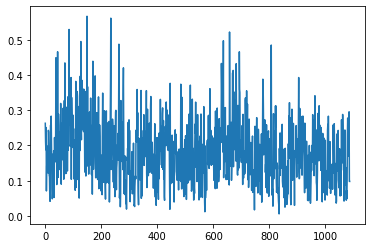

In [44]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.01
epochs = 2
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(argument_decoder.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[2]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(argument_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     argument_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(argument_decoder.state_dict(), 'argument_decoder.pt')

show_plot(plot_losses)

# Action Predictor Eval

In [35]:
def evaluate(encoder, predictor, sentence, encoder_lang, action_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        predictor_output = predictor(encoder_hidden.flatten())
        topv, topi = predictor_output.topk(1)
        predicted_action = action_lang.word(topi.item())
        return predicted_action

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_predictor = ActionPredictor(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_predictor.pt'):
    action_predictor.load_state_dict(torch.load('action_predictor.pt'))

eval_pairs = [[sample[0], sample[1]] for sample in eval_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, action_predictor, sample[0], lang, action_lang)
    print(f"{' '.join(sample[0])} ({sample[1][0]}) -> {output} ({output == sample[1][0]})")
    results.append(output == sample[1][0])

samples: 1939
turn to the left and face the desk (GotoLocation) -> GotoLocation (True)
pick up the clock that is on the desk (PickupObject) -> PickupObject (True)
turn left then face the desk (GotoLocation) -> GotoLocation (True)
pick up the alarm clock on the desk (PickupObject) -> PickupObject (True)
turn on the lamp (ToggleObject) -> PutObject (False)
pick up the clock on the desk top (PickupObject) -> PickupObject (True)
turn on the lamp (ToggleObject) -> PutObject (False)
walk to face right side of desk (GotoLocation) -> GotoLocation (True)
pick up red and grey bottle from desk (PickupObject) -> PickupObject (True)
walk to desk on right side of room (GotoLocation) -> GotoLocation (True)
turn on lamp on the desk (ToggleObject) -> PutObject (False)
use the metal box to turn on the lamp (ToggleObject) -> GotoLocation (False)
pick up the alarm clock from the desk (PickupObject) -> PickupObject (True)
turn on the lamp on the desk (ToggleObject) -> PutObject (False)
walk forward a bit t

turn right and walk to the white sofa (GotoLocation) -> GotoLocation (True)
turn on the lamp next to the couch (ToggleObject) -> PutObject (False)
turn to your right walk towards the cabinet (GotoLocation) -> GotoLocation (True)
pick up the laptop on the cabinet (PickupObject) -> PickupObject (True)
turn on the lamp (ToggleObject) -> PutObject (False)
turn right walk forward to the dresser (GotoLocation) -> GotoLocation (True)
turn the lamp on (ToggleObject) -> PutObject (False)
turn to left then find the desk (GotoLocation) -> GotoLocation (True)
close the laptop then pick it up (PickupObject) -> PickupObject (True)
turn on the lamp on your left (ToggleObject) -> PutObject (False)
turn left and head towards the dresser (GotoLocation) -> GotoLocation (True)
turn right and head towards the white sofa (GotoLocation) -> GotoLocation (True)
turn on the floor lamp (ToggleObject) -> PutObject (False)
turn right and carry the computer to the sofa (GotoLocation) -> GotoLocation (True)
turn lef

pick up the salt shaker from the counter (PickupObject) -> PickupObject (True)
turn left and walk to the counter (GotoLocation) -> GotoLocation (True)
take the salt bottle near the coffee machine (PickupObject) -> PickupObject (True)
turn left and face the coffee machine (GotoLocation) -> GotoLocation (True)
turn left then straight back to the counter top (GotoLocation) -> GotoLocation (True)
take the salt from the counter (PickupObject) -> PickupObject (True)
turn left go forward stop at the stove (GotoLocation) -> GotoLocation (True)
pick up the salt shaker from the counter top (PickupObject) -> PickupObject (True)
turn left and walk to the coffee maker (GotoLocation) -> GotoLocation (True)
pick up the salt shaker (PickupObject) -> PickupObject (True)
turn left and walk past the stove (GotoLocation) -> GotoLocation (True)
pick up the salt shaker off of the counter (PickupObject) -> PickupObject (True)
move left towards the toilet (GotoLocation) -> GotoLocation (True)
pick up the plun

turn around to the sink (GotoLocation) -> GotoLocation (True)
put the pan in the sink (PutObject) -> PutObject (True)
walk to the pan on the stove (GotoLocation) -> GotoLocation (True)
place the knife in the pan on the stove (PutObject) -> PutObject (True)
pick up the pan on the stove (PickupObject) -> PickupObject (True)
turn around and walk to the sink (GotoLocation) -> GotoLocation (True)
place the pan in the sink (PutObject) -> PutObject (True)
pick up a knife off of the kitchen counter (PickupObject) -> PickupObject (True)
drop the knife in to the frying pan (PutObject) -> PutObject (True)
turn right around and face the sink (GotoLocation) -> GotoLocation (True)
drop the frying pan in to the sink (PutObject) -> PutObject (True)
bring the bowl up toward the counter (GotoLocation) -> GotoLocation (True)
turn to the counter and pick up the egg (PickupObject) -> PickupObject (True)
open the cabinet and place egg in bowl (PutObject) -> PutObject (True)
remove bowl in the cabinet (Picku

go to the counter right of the stove (GotoLocation) -> GotoLocation (True)
pick up a spoon on the counter (PickupObject) -> PickupObject (True)
go to the stove (GotoLocation) -> GotoLocation (True)
place the spoon in a pan (PutObject) -> PutObject (True)
pick up the pan from the stove (PickupObject) -> PickupObject (True)
turn to the sink (GotoLocation) -> GotoLocation (True)
place the pan and spoon in the sink (PutObject) -> PutObject (True)
pick up spoon from counter behind shaker (PickupObject) -> PickupObject (True)
turn around and go to sink (GotoLocation) -> GotoLocation (True)
put pan with spoon in center of sink (PutObject) -> PutObject (True)
pick up the spoon from beside the plant (PickupObject) -> PickupObject (True)
turn to the left and walk to the stove (GotoLocation) -> GotoLocation (True)
place the spoon into the front left skillet (PutObject) -> PutObject (True)
pick up the skillet (PickupObject) -> PickupObject (True)
turn to the left and walk to the sink (GotoLocation

cut the lettuce (SliceObject) -> SliceObject (True)
go to the middle of the counter (GotoLocation) -> GotoLocation (True)
put the butterknife down (PutObject) -> PutObject (True)
go to the left part of the counter (GotoLocation) -> GotoLocation (True)
pick up a lettuce piece (PickupObject) -> PickupObject (True)
go to the sink (GotoLocation) -> GotoLocation (True)
wash the lettuce (CleanObject) -> SliceObject (False)
go to the black bin (GotoLocation) -> GotoLocation (True)
put the lettuce in the bin (PutObject) -> PutObject (True)
turn left move to in front of the refrigerator (GotoLocation) -> GotoLocation (True)
slice the lettuce in the refrigerator (SliceObject) -> SliceObject (True)
move to in front of the refrigerator (GotoLocation) -> GotoLocation (True)
put the knife in the refrigerator (PutObject) -> PutObject (True)
move to in front of the refrigerator (GotoLocation) -> GotoLocation (True)
pick up a slice of lettuce (PickupObject) -> PickupObject (True)
put the slice of lettu

stay at the counter (GotoLocation) -> GotoLocation (True)
stay at the counter (GotoLocation) -> GotoLocation (True)
take a slice of bread from the counter (PickupObject) -> PickupObject (True)
turn left go to the white refrigerator (GotoLocation) -> GotoLocation (True)
turn right go in front of the oven (GotoLocation) -> GotoLocation (True)
put the bread in the microwave above the oven (PutObject) -> PutObject (True)
slice the right half of the loaf of bread (SliceObject) -> SliceObject (True)
move one step to the right (GotoLocation) -> GotoLocation (True)
go back one step to the left (GotoLocation) -> GotoLocation (True)
move to your right to stand facing the stove (GotoLocation) -> GotoLocation (True)
pick up the knife from the counter (PickupObject) -> PickupObject (True)
cut the loaf of bread (SliceObject) -> SliceObject (True)
move one step to your right (GotoLocation) -> GotoLocation (True)
place the knife on the counter (PutObject) -> PutObject (True)
walk one step to the left 

pick up the pan on the stove (PickupObject) -> PickupObject (True)
walk left back to the fridge (GotoLocation) -> GotoLocation (True)
walk a few step right (GotoLocation) -> GotoLocation (True)
go left and stand in front of the fridge (GotoLocation) -> GotoLocation (True)
place the pan on the counter (PutObject) -> PutObject (True)
take a step to your right (GotoLocation) -> GotoLocation (True)
pick up the pan on the front left burner (PickupObject) -> PickupObject (True)
pick up the pan on the front left burner (PickupObject) -> PickupObject (True)
turn left to carry the pan to the fridge (GotoLocation) -> GotoLocation (True)
put the pan on the counter top (PutObject) -> PutObject (True)
grab a pan from the stove (PickupObject) -> PickupObject (True)
place the pan in the fridge then grab it (CoolObject) -> HeatObject (False)
place the pan on the counter (PutObject) -> PutObject (True)
pick up the pan on the stove (PickupObject) -> PickupObject (True)
turn left then walk straight head 

put the apple in the sink (PutObject) -> PutObject (True)
turn left go straight turn right into kitchen (GotoLocation) -> GotoLocation (True)
pick up apple in the sink (PickupObject) -> PickupObject (True)
hold apple open microwave door (GotoLocation) -> GotoLocation (True)
place apple into microwave close microwave (HeatObject) -> PutObject (False)
cook apple in microwave open microwave grab apple (GotoLocation) -> PickupObject (False)
turn around towards sink throw apple into sink (PutObject) -> GotoLocation (False)
heat the apple in the microwave (HeatObject) -> HeatObject (True)
return to the sink behind you (GotoLocation) -> GotoLocation (True)
put the apple back in the sink (PutObject) -> PutObject (True)
turn around to the microwave above the stove (GotoLocation) -> GotoLocation (True)
cook the apple in the microwave (HeatObject) -> HeatObject (True)
turn around to the sink behind you (GotoLocation) -> GotoLocation (True)
move to the sink (GotoLocation) -> GotoLocation (True)
br

remove mug from inside coffee maker (PickupObject) -> PickupObject (True)
walk to face microwave (GotoLocation) -> GotoLocation (True)
heat mug in microwave remove from microwave (HeatObject) -> HeatObject (True)
gaze to the cabinet left of the microwave (GotoLocation) -> GotoLocation (True)
put mug inside cabinet (PutObject) -> PutObject (True)
pick up the mug from the coffee machine (PickupObject) -> PickupObject (True)
walk back to the coffee machine (GotoLocation) -> GotoLocation (True)
place the mug in the coffee machine (PutObject) -> PutObject (True)
pick up the mug on the coffee maker (PickupObject) -> PickupObject (True)
put the mug on the coffee maker (PutObject) -> PutObject (True)
walk to the coffee pot (GotoLocation) -> GotoLocation (True)
carry the cup to the microwave (GotoLocation) -> GotoLocation (True)
put the coffee cup in the microwave (HeatObject) -> PutObject (False)
take the coffee cup out of the microwave (GotoLocation) -> PickupObject (False)
carry the cup back

place the tomato in the sink (PutObject) -> PutObject (True)
turn around and go to the sink (GotoLocation) -> GotoLocation (True)
cut the tomato in the sink into slice (SliceObject) -> SliceObject (True)
place the knife in the sink (PutObject) -> PutObject (True)
pick up one of the tomato slice (PickupObject) -> PickupObject (True)
turn back around to the sink (GotoLocation) -> GotoLocation (True)
place the tomato slice in the sink (PutObject) -> PutObject (True)
take the apple closer to you from the sink (PickupObject) -> PickupObject (True)
take the apple from the sink (PickupObject) -> PickupObject (True)
take the small knife from under the lettuce (PickupObject) -> PickupObject (True)
cut both apple into piece on the counter (SliceObject) -> SliceObject (True)
pick up the green apple closest to you (PickupObject) -> PickupObject (True)
turn around and walk back to the sink (GotoLocation) -> GotoLocation (True)
pick up the remaining apple in the sink (PickupObject) -> PickupObject (

turn left to return to the blue chair (GotoLocation) -> GotoLocation (True)
pick up the pillow on the blue chair (PickupObject) -> PickupObject (True)
pick up a pillow from the chair (PickupObject) -> PickupObject (True)
move to the middle of the couch (GotoLocation) -> GotoLocation (True)
put the pillow on the couch (PutObject) -> PutObject (True)
pick up a pillow from the chair (PickupObject) -> PickupObject (True)
move to the middle of the couch (GotoLocation) -> GotoLocation (True)
put the pillow on the couch (PutObject) -> PutObject (True)
turn around and locate the chair (GotoLocation) -> GotoLocation (True)
pick up the pillow from the chair (PickupObject) -> PickupObject (True)
turn right and head for the sofa (GotoLocation) -> GotoLocation (True)
drop the pillow on the sofa (PutObject) -> PutObject (True)
turn left and head for the chair (GotoLocation) -> GotoLocation (True)
pick up the other pillow (PickupObject) -> PickupObject (True)
turn right towards the sofa (GotoLocation

In [36]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.9009798865394534


# Eval Action / Arguments

In [45]:
def evaluate(encoder, action_decoder, argument_decoder, sentence, encoder_lang, action_decoder_lang, argument_decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        # Action Decoder
        action_decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS
        action_decoder_hidden = encoder_hidden
        action_decoded_words = []
        action_decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, action_decoder_hidden, decoder_attention = action_decoder(
                action_decoder_input, action_decoder_hidden, encoder_outputs)
            action_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                action_decoded_words.append('<EOS>')
                break
            else:
                action_decoded_words.append(action_decoder_lang.word(topi.item()))
        
            action_decoder_input = topi.squeeze().detach()
        
        # Argument Decoder
        argument_decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS
        argument_decoder_hidden = encoder_hidden
        argument_decoded_words = []
        argument_decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, argument_decoder_hidden, decoder_attention = argument_decoder(
                argument_decoder_input, argument_decoder_hidden, encoder_outputs)
            argument_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                argument_decoded_words.append('<EOS>')
                break
            else:
                argument_decoded_words.append(argument_decoder_lang.word(topi.item()))

            argument_decoder_input = topi.squeeze().detach()

        return action_decoded_words, argument_decoded_words

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    action_decoder.load_state_dict(torch.load('action_decoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, action_decoder, argument_decoder, sample[0], lang, action_lang, argument_lang)
    arg_result = output[1][0] == sample[2][0]
    if len(sample[2]) > 1:
        arg_result &= output[1][1] == sample[2][1]
    print(output[1][:-1], sample[2])
    results.append(output[0][0] == sample[1][0] and arg_result)

samples: 1939
['shelf'] ['desk']
['alarmclock'] ['alarmclock']
['diningtable'] ['desk']
['alarmclock'] ['alarmclock']
['floorlamp'] ['desklamp']
['alarmclock'] ['alarmclock']
['floorlamp'] ['desklamp']
['diningtable'] ['desk']
['winebottle'] ['alarmclock']
['shelf'] ['desklamp']
['desklamp'] ['desklamp']
['floorlamp'] ['desklamp']
['alarmclock'] ['alarmclock']
['desklamp'] ['desklamp']
['shelf'] ['baseballbat']
['baseballbat'] ['baseballbat']
['desklamp'] ['desklamp']
['baseballbat'] ['baseballbat']
['floorlamp'] ['desklamp']
['countertop'] ['baseballbat']
['baseballbat'] ['baseballbat']
['shelf'] ['desklamp']
['desklamp'] ['desklamp']
['shelf'] ['baseballbat']
['baseballbat'] ['baseballbat']
['shelf'] ['desklamp']
['desklamp'] ['desklamp']
['baseballbat'] ['baseballbat']
['desklamp'] ['desklamp']
['baseballbat'] ['baseballbat']
['floorlamp'] ['desklamp']
['shelf'] ['baseballbat']
['baseballbat'] ['baseballbat']
['desklamp'] ['desklamp']
['baseballbat'] ['baseballbat']
['floorlamp'] ['

['toiletpaperhanger'] ['countertop']
['winebottle'] ['peppershaker']
['countertop'] ['countertop']
['countertop'] ['countertop']
['saltshaker'] ['peppershaker']
['stoveburner'] ['drawer']
['saltshaker'] ['peppershaker']
['cabinet'] ['countertop']
['saltshaker'] ['peppershaker']
['countertop'] ['drawer']
['saltshaker'] ['peppershaker']
['toilet'] ['plunger']
['plunger'] ['plunger']
['countertop'] ['cabinet']
['plunger'] ['plunger', 'cabinet']
['plunger'] ['plunger']
['shelf'] ['cabinet']
['sinkbasin'] ['plunger']
['cabinet'] ['cabinet']
['toilet'] ['plunger']
['plunger'] ['plunger']
['cabinet'] ['cabinet']
['toiletpaperhanger'] ['plunger']
['shelf'] ['shelf']
['saltshaker'] ['saltshaker']
['shelf'] ['shelf']
['saltshaker'] ['saltshaker']
['fridge'] ['cabinet']
['shelf'] ['shelf']
['saltshaker'] ['saltshaker']
['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
['saltshaker'] ['saltshaker']
['shelf'] ['shelf']
['saltshaker'] ['saltshaker']
['shelf'] ['shelf']
['saltshaker'] ['saltshaker'

['shelf'] ['bowl']
['pencil', 'shelf'] ['pencil', 'bowl']
['spoon'] ['spoon']
['mug'] ['mug']
['mug', 'cabinet'] ['mug', 'countertop']
['spoon'] ['spoon']
['vase'] ['mug']
['fridge'] ['mug']
['countertop'] ['mug']
['spoon', 'drawer'] ['spoon', 'mug']
['countertop'] ['countertop']
['spoon'] ['spoon']
['fridge'] ['mug']
['vase'] ['mug']
['mug', 'countertop'] ['mug', 'countertop']
['spoon'] ['spoon']
['fridge'] ['mug']
['mug'] ['mug']
['countertop'] ['countertop']
['spoon'] ['spoon']
['fridge'] ['mug']
['spoon', 'sinkbasin'] ['spoon', 'mug']
['cup'] ['mug']
['mug', 'countertop'] ['mug', 'countertop']
['fridge'] ['mug']
['mug'] ['mug']
['mug', 'countertop'] ['mug', 'countertop']
['spoon'] ['spoon']
['spoon', 'pan'] ['spoon', 'pan']
['pot'] ['pan']
['spoon'] ['sinkbasin']
['pot', 'sinkbasin'] ['pan', 'sinkbasin']
['countertop'] ['countertop']
['spoon'] ['spoon']
['stoveburner'] ['pan']
['spoon', 'pan'] ['spoon', 'pan']
['pot'] ['pan']
['countertop'] ['sinkbasin']
['pot', 'sinkbasin'] ['pan'

['soapbar'] ['soapbar']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['sinkbasin'] ['countertop']
['soapbottle'] ['soapbar']
['shelf'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['toiletpaper'] ['soapbar']
['countertop'] ['countertop']
['toiletpaper'] ['soapbar']
['sinkbasin'] ['sinkbasin']
['toiletpaper'] ['soapbar']
['countertop'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['toilet'] ['countertop']
['soapbar'] ['soapbar']
['sinkbasin'] ['sinkbasin']
['toiletpaperhanger'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['sinkbasin'] ['countertop']
['toiletpaper'] ['soapbar']
['countertop'] ['sinkbasin']
['toiletpaper'] ['soapbar']
['garbagecan'] ['countertop']
['toiletpaper', 'countertop'] ['soapbar', 'countertop']
['diningtable'] ['countertop']
['spatula'] ['spatula']
['sinkbasin'] ['sinkbasin']
['dresser'] ['drawer']
['shelf'] ['countertop']
['spatula'] ['spatula']
['countertop'] ['sinkbasin']


['tomato'] ['tomato']
['fridge'] ['fridge']
['countertop'] ['countertop']
['knife'] ['knife']
['countertop'] ['tomato']
['tomato'] ['tomato']
['knife', 'countertop'] ['knife', 'countertop']
['tomato'] ['tomato']
['fridge'] ['fridge']
['tomato'] ['tomato']
['countertop'] ['countertop']
['tomato', 'countertop'] ['tomato', 'countertop']
['coffeetable'] ['countertop']
['knife'] ['knife']
['desk'] ['tomato']
['tomato'] ['tomato']
['knife', 'sidetable'] ['knife', 'countertop']
['tomato'] ['tomato']
['fridge'] ['fridge']
['desk'] ['countertop']
['tissuebox', 'sidetable'] ['tomato', 'countertop']
['knife'] ['butterknife']
['tomato'] ['tomato']
['fridge'] ['fridge']
['knife', 'fridge'] ['butterknife', 'fridge']
['countertop'] ['countertop']
['tomato'] ['tomato']
['fridge'] ['fridge']
['countertop'] ['countertop']
['tomato', 'countertop'] ['tomato', 'countertop']
['fridge'] ['fridge']
['countertop'] ['countertop']
['fridge'] ['fridge']
['countertop'] ['countertop']
['knife'] ['butterknife']
['co

['knife'] ['butterknife']
['potato'] ['potato']
['knife', 'garbagecan'] ['butterknife', 'garbagecan']
['stoveburner'] ['microwave']
['fridge'] ['fridge']
['butterknife'] ['butterknife']
['knife', 'garbagecan'] ['butterknife', 'garbagecan']
['potato', 'fridge'] ['potato', 'fridge']
['coffeetable'] ['countertop']
['knife'] ['butterknife']
['fridge'] ['potato']
['potato'] ['potato']
['shelf'] ['shelf']
['knife', 'countertop'] ['butterknife', 'shelf']
['fridge'] ['fridge']
['potato'] ['potato']
['stoveburner'] ['microwave']
['fridge'] ['fridge']
['potato', 'fridge'] ['potato', 'fridge']
['knife'] ['butterknife']
['shelf'] ['shelf']
['knife', 'countertop'] ['butterknife', 'shelf']
['fridge'] ['fridge']
['potato'] ['potato']
['potato', 'fridge'] ['potato', 'fridge']
['fridge'] ['potato']
['knife', 'cart'] ['butterknife', 'shelf']
['fridge'] ['fridge']
['potato'] ['potato']
['tomato'] ['microwave']
['fridge'] ['fridge']
['knife'] ['butterknife']
['countertop'] ['potato']
['potato'] ['potato']

['sofa'] ['sofa']
['pillow', 'sofa'] ['pillow', 'sofa']
['armchair'] ['armchair']
['vase'] ['pillow']
['sofa'] ['sofa']
['pillow', 'sofa'] ['pillow', 'sofa']
['pillow'] ['pillow']
['toiletpaperhanger'] ['armchair']
['pillow'] ['pillow']
['sidetable'] ['sofa']
['pillow'] ['pillow']
['pillow'] ['pillow']
['sofa'] ['sofa']
['pillow', 'countertop'] ['pillow', 'sofa']
['pillow'] ['pillow']
['armchair'] ['armchair']
['pillow'] ['pillow']
['sofa'] ['sofa']
['pillow'] ['pillow']
['armchair'] ['armchair']
['pillow'] ['pillow']
['pillow'] ['pillow']
['pillow'] ['pillow']
['armchair'] ['armchair']
['soapbar'] ['soapbar']
['toilet'] ['toilet']
['vase'] ['soapbar']
['countertop'] ['countertop']
['toiletpaper'] ['soapbar']
['cabinet'] ['cabinet']
['countertop'] ['countertop']
['cabinet'] ['cabinet']
['drawer'] ['cabinet']
['soapbar'] ['soapbar']
['drawer'] ['cabinet']
['sinkbasin'] ['countertop']
['cabinet'] ['cabinet']
['countertop'] ['countertop']
['cabinet'] ['cabinet']
['sinkbasin'] ['countertop

In [46]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.5786487880350696
